In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from lcdb.db import LCDB
df = LCDB().get_results(workflows=["lcdb.workflow.sklearn.LibLinearWorkflow"], openmlids=[3,6,11,12,14], return_generator=False)     # 3,6,11,12,14

Choose feature column for predicting runtime

In [3]:
selected_columns = df[['p:pp@cat_encoder', 'p:pp@decomposition', 'p:pp@featuregen', 'p:pp@featureselector', 'p:pp@scaler', 
                    'p:pp@kernel_pca_kernel', 'p:pp@kernel_pca_n_components', 'p:pp@poly_degree', 'p:pp@selectp_percentile',
                    'p:pp@std_with_std', 'm:openmlid', 'm:json']].copy()

replacement_dict = {
    3: 37,
    6: 17,
    11: 5,
    12: 217,
    14: 77,
}

selected_columns['m:openmlid'] = selected_columns['m:openmlid'].replace(replacement_dict)

# rename
selected_columns = selected_columns.rename(columns={'m:openmlid': 'original_feature_number'})

Use 'fit' times as our prediction goal

In [4]:
def extract_runtimes(info):
    runtime_anchor = []

    for child in info.get('children', []):
        if child['tag'] == 'build_curves':
            # extract anchor under build_curves
            for anchor in child.get('children', []):
                if anchor['tag'] == 'anchor':
                    # extract the training set size
                    anchor_value = anchor.get('metadata', {}).get('value')

                    # Initialize fit_time and predict_time as None
                    fit_time = None
                    predict_time = None

                    for runtime in anchor.get('children', []):
                        # extract the fit time
                        if runtime['tag'] == 'fit':
                            fit_time = runtime['timestamp_stop'] - runtime['timestamp_start']
                            
                        if runtime['tag'] == 'get_predictions': 
                            predict_time = runtime['timestamp_stop'] - runtime['timestamp_start']

                    # Only append if both fit_time and predict_time are found
                    if fit_time is not None and predict_time is not None:
                        runtime_anchor.append((anchor_value, fit_time, predict_time))

    return runtime_anchor


In [5]:
expanded_rows = []

for _, row in tqdm(selected_columns.iterrows()):
    extracted_data = extract_runtimes(row['m:json'])
    for data in extracted_data:
        new_row = row.copy()  
        new_row['anchor_value'] = data[0]
        new_row['fit_time'] = data[1]
        new_row['predict_time'] = data[2]
        expanded_rows.append(new_row)

runtime_estimation_df = pd.DataFrame(expanded_rows)

# remove m:json
runtime_estimation_df = runtime_estimation_df.drop(columns=['m:json'])


11980it [02:05, 95.52it/s] 


In [8]:
categorical_columns = [
    'p:pp@cat_encoder', 'p:pp@decomposition', 'p:pp@featuregen', 
    'p:pp@featureselector', 'p:pp@scaler', 'p:pp@kernel_pca_kernel', 
    'p:pp@kernel_pca_n_components', 'p:pp@poly_degree', 
    'p:pp@selectp_percentile', 'p:pp@std_with_std'
]

label_encoders = {}

# Apply Label Encoding to categorical columns
for column in categorical_columns:
    if column in runtime_estimation_df.columns:
        # Check if the column is numeric or contains boolean values
        if not pd.api.types.is_numeric_dtype(runtime_estimation_df[column]) or pd.api.types.is_bool_dtype(runtime_estimation_df[column]):
            # Initialize label encoder
            le = LabelEncoder()
            
            # Apply Label Encoding
            runtime_estimation_df[column] = le.fit_transform(runtime_estimation_df[column].astype(str))
            
            # Store the encoder
            label_encoders[column] = le


In [10]:
# Save the DataFrame to an HDF5 file
hdf5_file_path = '/mnt/c/Users/cyan1/code/lcdb/publications/2023-neurips/runtime_estimation_data.h5py'
runtime_estimation_df.to_hdf(hdf5_file_path, key='data', mode='w')

print(f'DataFrame successfully saved to {hdf5_file_path}')

DataFrame successfully saved to /mnt/c/Users/cyan1/code/lcdb/publications/2023-neurips/runtime_estimation_data.h5py


### regress

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
hdf5_file_path = '/mnt/c/Users/cyan1/code/lcdb/publications/2023-neurips/runtime_estimation_data.h5py'
runtime_estimation_df = pd.read_hdf(hdf5_file_path, key='data')

In [3]:
runtime_estimation_df

,p:pp@cat_encoder,p:pp@decomposition,p:pp@featuregen,p:pp@featureselector,p:pp@scaler,p:pp@kernel_pca_kernel,p:pp@kernel_pca_n_components,p:pp@poly_degree,p:pp@selectp_percentile,p:pp@std_with_std,original_feature_number,anchor_value,fit_time,predict_time
5,0,6,0,0,1,0,0.25,2,25,1,37,16,0.0196,0.0145
5,0,6,0,0,1,0,0.25,2,25,1,37,23,0.0167,0.0132
5,0,6,0,0,1,0,0.25,2,25,1,37,32,0.0166,0.0133
5,0,6,0,0,1,0,0.25,2,25,1,37,45,0.0163,0.0128
5,0,6,0,0,1,0,0.25,2,25,1,37,64,0.0168,0.0131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,0,6,0,1,0,0,0.25,2,53,1,77,512,0.1005,0.0040
90,0,6,0,1,0,0,0.25,2,53,1,77,724,0.1548,0.0042
90,0,6,0,1,0,0,0.25,2,53,1,77,1024,0.2411,0.0053
90,0,6,0,1,0,0,0.25,2,53,1,77,1448,0.3946,0.0051


In [3]:
X = runtime_estimation_df.drop(columns=['fit_time', 'predict_time'])
# X = runtime_estimation_df[['original_feature_number', 'anchor_value']]
y1 = runtime_estimation_df['fit_time']
y2 = runtime_estimation_df['predict_time']

In [4]:
models = {
    'Linear Regression': LinearRegression(),
    'Neural Network': MLPRegressor(),   # hidden_layer_sizes=(32, 32)
    'Random Forest': RandomForestRegressor()
}

random_states = [0, 1, 2, 3, 4]

train_sizes_percent = np.arange(0.1, 1.0, 0.1) # from 0.1 to 0.9

# Store RMSE results
results_y1 = {}
results_y2 = {}

def evaluate_model(models, X, y, target_name):
    results = {}
    with tqdm(total=len(models) * len(train_sizes_percent) * len(random_states), desc=f'Evaluating {target_name}') as pbar:
        for name, model in models.items():
            test_errors_all = []
            
            for train_size in train_sizes_percent:
                test_errors = []
                
                for random_state in random_states:
                    pbar.set_postfix_str(f'Model: {name}, Train size: {train_size}, Seed: {random_state}')
                    pbar.update(1)
                    # print(f"Model {name} ({target_name}) Train size {train_size} Random seed {random_state}")
                    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=0.1, random_state=random_state)
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                    test_errors.append(rmse)
                
                test_errors_all.append(test_errors)
            
            results[name] = test_errors_all
    
    return results




In [5]:
results_y1 = evaluate_model(models, X, y1, 'fit_time')
results_y2 = evaluate_model(models, X, y2, 'predict_time')

Evaluating fit_time:  58%|█████▊    | 78/135 [21:26<1:50:55, 116.77s/it, Model: Neural Network, Train size: 0.7000000000000001, Seed: 2] /home/cyan1/miniconda3/envs/lcdb2/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Evaluating fit_time:  61%|██████    | 82/135 [30:14<1:40:03, 113.28s/it, Model: Neural Network, Train size: 0.8, Seed: 1]               /home/cyan1/miniconda3/envs/lcdb2/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Evaluating fit_time:  61%|██████▏   | 83/135 [34:42<2:18:25, 159.72s/it, Model: Neural Network, Train size: 0.8, Seed: 2]/home/cyan1/miniconda3/envs/lcdb2/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perc

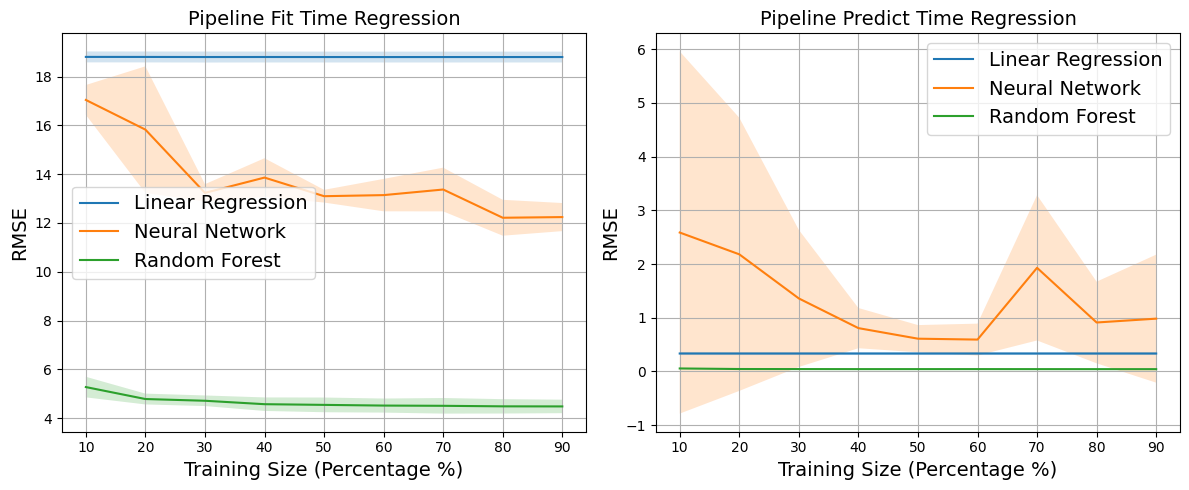

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for name in models.keys():

    errors_y1 = np.array(results_y1[name])
    mean_y1 = np.mean(errors_y1, axis=1)
    std_y1 = np.std(errors_y1, axis=1)
    axes[0].plot(train_sizes_percent * 100, mean_y1, label=name)
    axes[0].fill_between(train_sizes_percent * 100, mean_y1 - std_y1, mean_y1 + std_y1, alpha=0.2)

    errors_y2 = np.array(results_y2[name])
    mean_y2 = np.mean(errors_y2, axis=1)
    std_y2 = np.std(errors_y2, axis=1)
    axes[1].plot(train_sizes_percent * 100, mean_y2, label=name)
    axes[1].fill_between(train_sizes_percent * 100, mean_y2 - std_y2, mean_y2 + std_y2, alpha=0.2)

axes[0].set_xlabel('Training Size (Percentage %)',fontsize=14)
axes[0].set_ylabel('RMSE',fontsize=14)
axes[0].set_title('Pipeline Fit Time Regression',fontsize=14)
axes[0].legend(fontsize=14)
axes[0].grid(True)

axes[1].set_xlabel('Training Size (Percentage %)',fontsize=14)
axes[1].set_ylabel('RMSE',fontsize=14)
axes[1].set_title('Pipeline Predict Time Regression',fontsize=14)
axes[1].legend(fontsize=14)
axes[1].grid(True)

plt.tight_layout()  
plt.show()
